## Notebook to find the Best Performing Model

### Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


### Loading Dataset

In [2]:
# Loading a smaller subset of the training data for quicker iterations
train_data = pd.read_csv('train.csv').sample(frac=0.1, random_state=42)

# Loading the test data
test_data = pd.read_csv('test.csv')

# Checking for missing values
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()
print("Missing values in training data:\n", missing_values_train)
print("Missing values in test data:\n", missing_values_test)


Missing values in training data:
 tweets    0
class     0
dtype: int64
Missing values in test data:
 tweets    2
class     9
dtype: int64


Class distribution in training data:
 class
irony         2186
figurative    2086
sarcasm       2044
regular       1825
Name: count, dtype: int64


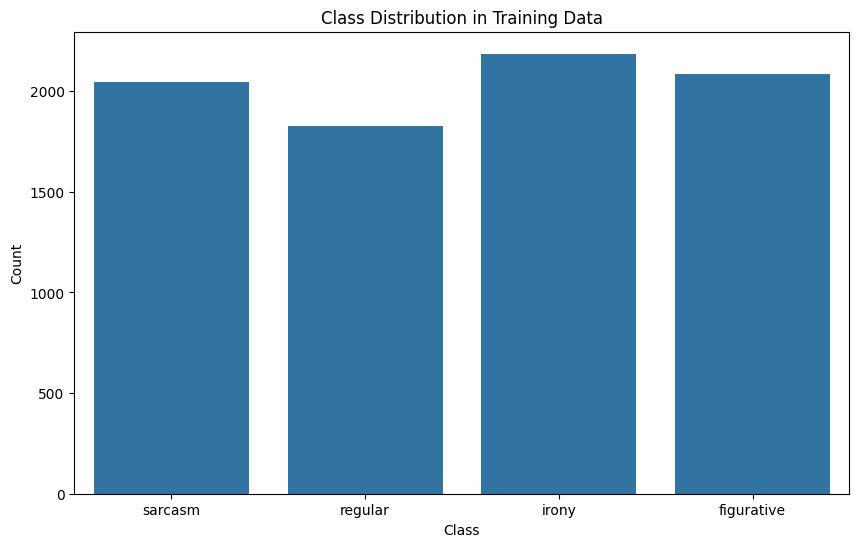

In [3]:
# Analyzing the distribution of the classes
class_distribution = train_data['class'].value_counts()
print("Class distribution in training data:\n", class_distribution)

# Plotting class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Tweet length stats:
 count    8141.000000
mean      102.872497
std        30.706048
min         6.000000
25%        78.000000
50%       109.000000
75%       132.000000
max       152.000000
Name: tweet_length, dtype: float64


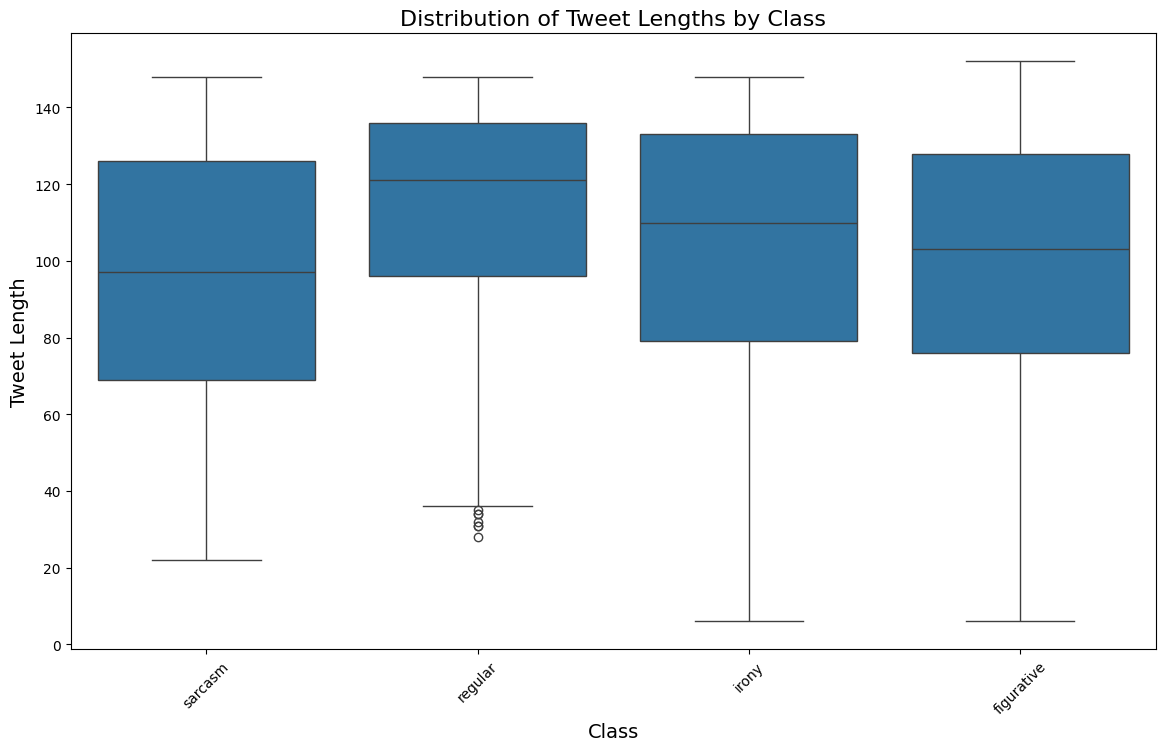

In [4]:
# Calculating the length of each tweet
train_data['tweet_length'] = train_data['tweets'].apply(len)
tweet_length_stats = train_data['tweet_length'].describe()
print("Tweet length stats:\n", tweet_length_stats)

# Plotting tweet length distribution by class
plt.figure(figsize=(14, 8))
sns.boxplot(x='class', y='tweet_length', data=train_data)
plt.title('Distribution of Tweet Lengths by Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Tweet Length', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Preprocessing the text
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^A-Za-z0-9\s]', '', text)
        text = text.lower()
    else:
        text = ""
    return text
train_data['clean_tweets'] = train_data['tweets'].apply(preprocess_text)
test_data['clean_tweets'] = test_data['tweets'].apply(preprocess_text)

# Combining all tweets into a single string for word frequency
all_words = ' '.join(train_data['clean_tweets'])
word_freq = Counter(all_words.split())

# Displaying the 10 most common words
common_words = word_freq.most_common(10)
print("Most common words:\n", common_words)

Most common words:
 [('the', 3480), ('to', 2548), ('a', 2201), ('i', 1606), ('of', 1524), ('is', 1442), ('in', 1413), ('and', 1291), ('for', 1109), ('you', 1099)]


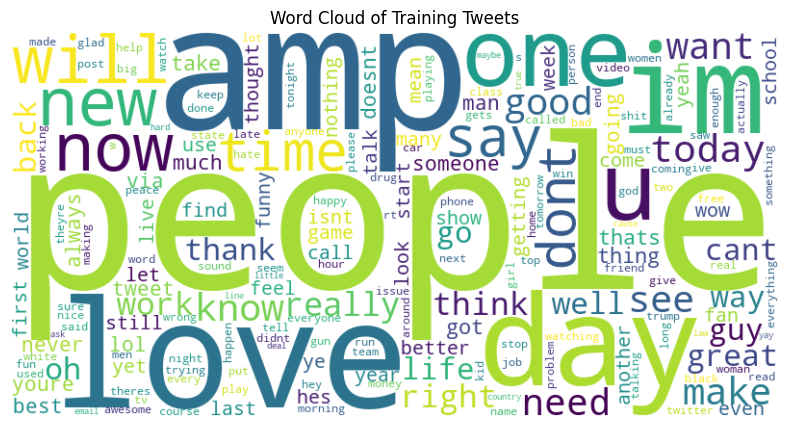

In [6]:
# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Training Tweets')
plt.axis('off')
plt.show()

In [7]:
# Labelling sarcasm as 1 and others as 0
train_data['binary_class'] = train_data['class'].apply(lambda x: 1 if x == 'sarcasm' else 0)
test_data['binary_class'] = test_data['class'].apply(lambda x: 1 if x == 'sarcasm' else 0)

# Splitting data into training and testing sets
X_train = train_data['clean_tweets']
y_train = train_data['binary_class']
X_test = test_data['clean_tweets']
y_test = test_data['binary_class']


In [8]:
# Defining the pipeline for Logistic Regression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduced features for speed
    ('clf', LogisticRegression(max_iter=100))
])
pipeline_lr

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('clf', LogisticRegression())])

In [9]:
# Defining the pipeline for SVM
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduced features for speed
    ('clf', SVC())
])
pipeline_svm

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)), ('clf', SVC())])

In [10]:
# Training and evaluate Logistic Regression
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Training and evaluating SVM
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85      6023
           1       0.52      0.14      0.22      2105

    accuracy                           0.74      8128
   macro avg       0.64      0.55      0.53      8128
weighted avg       0.70      0.74      0.68      8128

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      6023
           1       0.52      0.08      0.13      2105

    accuracy                           0.74      8128
   macro avg       0.64      0.53      0.49      8128
weighted avg       0.69      0.74      0.66      8128



In [11]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")


In [12]:
# Evaluating Logistic Regression
print("Logistic Regression Performance:")
evaluate_model(y_test, y_pred_lr)

# Evaluating SVM
print("SVM Performance:")
evaluate_model(y_test, y_pred_svm)


Logistic Regression Performance:
Accuracy: 0.7438484251968503
Precision: 0.5207956600361664
Recall: 0.1368171021377672
F1 Score: 0.21670428893905191
SVM Performance:
Accuracy: 0.7424950787401575
Precision: 0.5194805194805194
Recall: 0.07600950118764846
F1 Score: 0.1326150020721094


In [13]:
# Hyperparameter tuning for Logistic Regression with GridSearchCV
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)  # Reduced cv for speed
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

In [14]:
# Hyperparameter tuning for SVM with GridSearchCV
param_grid_svm = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='f1', n_jobs=-1)  # Reduced cv for speed
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

In [15]:
# Evaluating Tuned Logistic Regression 
y_pred_lr_tuned = best_lr.predict(X_test)
print("Tuned Logistic Regression with SMOTE Classification Report:\n", classification_report(y_test, y_pred_lr_tuned))

# Evaluate Tuned SVM
y_pred_svm_tuned = best_svm.predict(X_test)
print("Tuned SVM with SMOTE Classification Report:\n", classification_report(y_test, y_pred_svm_tuned))

Tuned Logistic Regression with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      6023
           1       0.46      0.26      0.34      2105

    accuracy                           0.73      8128
   macro avg       0.62      0.58      0.58      8128
weighted avg       0.69      0.73      0.70      8128

Tuned SVM with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      6023
           1       0.47      0.24      0.32      2105

    accuracy                           0.73      8128
   macro avg       0.62      0.57      0.58      8128
weighted avg       0.69      0.73      0.70      8128



In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Preprocess the text with additional steps
def advanced_preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^A-Za-z0-9\s]', '', text)
        text = text.lower()
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    else:
        text = ""
    return text

train_data['clean_tweets'] = train_data['tweets'].apply(advanced_preprocess_text)
test_data['clean_tweets'] = test_data['tweets'].apply(advanced_preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from gensim.models import Word2Vec

# Tokenize the tweets
train_data['tokenized_tweets'] = train_data['clean_tweets'].apply(lambda x: x.split())
test_data['tokenized_tweets'] = test_data['clean_tweets'].apply(lambda x: x.split())

# Train Word2Vec model on the training data
word2vec_model = Word2Vec(sentences=train_data['tokenized_tweets'], vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")


In [18]:
# Load the model
word2vec_model = Word2Vec.load("word2vec.model")

# Function to create word embeddings
def get_word2vec_embeddings(text, model):
    embeddings = np.zeros(100)
    for word in text:
        if word in model.wv.key_to_index:
            embeddings += model.wv[word]
    return embeddings

train_data['word2vec_embeddings'] = train_data['tokenized_tweets'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model))
test_data['word2vec_embeddings'] = test_data['tokenized_tweets'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model))


In [19]:
# Preparing the data for training
X_train_embeddings = np.stack(train_data['word2vec_embeddings'].values)
X_test_embeddings = np.stack(test_data['word2vec_embeddings'].values)

In [20]:
from sklearn.ensemble import VotingClassifier

# Define the individual models
lr = LogisticRegression(max_iter=100)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True)

# Combine models into an ensemble
ensemble = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('svm', svm)], voting='soft')


In [21]:
# Training the ensemble
ensemble.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble.predict(X_test_embeddings)
print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      6023
           1       0.00      0.00      0.00      2105

    accuracy                           0.74      8128
   macro avg       0.37      0.50      0.43      8128
weighted avg       0.55      0.74      0.63      8128



In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [23]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['clean_tweets'])

X_train_seq = tokenizer.texts_to_sequences(train_data['clean_tweets'])
X_test_seq = tokenizer.texts_to_sequences(test_data['clean_tweets'])


In [24]:
# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=50)
X_test_padded = pad_sequences(X_test_seq, maxlen=50)

In [25]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [26]:
 # Train the model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/5
115/115 [==============================] - 37s 277ms/step - loss: 0.5729 - accuracy: 0.7471 - val_loss: 0.5394 - val_accuracy: 0.7595
Epoch 2/5
115/115 [==============================] - 32s 276ms/step - loss: 0.4839 - accuracy: 0.7637 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 3/5
115/115 [==============================] - 37s 326ms/step - loss: 0.3713 - accuracy: 0.8213 - val_loss: 0.5543 - val_accuracy: 0.7374
Epoch 4/5
115/115 [==============================] - 33s 284ms/step - loss: 0.3059 - accuracy: 0.8601 - val_loss: 0.6096 - val_accuracy: 0.7313
Epoch 5/5
115/115 [==============================] - 31s 272ms/step - loss: 0.2517 - accuracy: 0.8894 - val_loss: 0.6881 - val_accuracy: 0.7190


In [27]:
# Evaluate the model
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype("int32")
print("LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm))

254/254 [==============================] - 7s 26ms/step
LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      6023
           1       0.42      0.32      0.36      2105

    accuracy                           0.71      8128
   macro avg       0.60      0.58      0.59      8128
weighted avg       0.69      0.71      0.70      8128



In [30]:
# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'lstm_units': [50, 100, 150],
    'epochs': [5, 10],
    'batch_size': [32, 64, 128]
}
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_result = random_search.fit(X_train_padded, y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/5
64/64 [==============================] - 12s 118ms/step - loss: 0.5849 - accuracy: 0.7374
Epoch 2/5
64/64 [==============================] - 9s 135ms/step - loss: 0.5397 - accuracy: 0.7493
Epoch 3/5
64/64 [==============================] - 7s 116ms/step - loss: 0.4494 - accuracy: 0.7789
Epoch 4/5
64/64 [==============================] - 8s 128ms/step - loss: 0.3834 - accuracy: 0.8128
Epoch 5/5
64/64 [==============================] - 8s 120ms/step - loss: 0.3439 - accuracy: 0.8404


In [31]:
# Get the best model
best_model = random_search_result.best_estimator_

In [32]:
# Evaluate the best model
y_pred_lstm_tuned = (best_model.predict(X_test_padded) > 0.5).astype("int32")
print("Tuned LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm_tuned))

64/64 [==============================] - 2s 24ms/step
Tuned LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83      6023
           1       0.46      0.28      0.35      2105

    accuracy                           0.73      8128
   macro avg       0.62      0.58      0.59      8128
weighted avg       0.70      0.73      0.70      8128



In [33]:
import pandas as pd
import random
from nltk.corpus import wordnet, stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# Define a function for synonym replacement
def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

# Augment the minority class
augmented_texts = []
for text in train_data[train_data['binary_class'] == 1]['clean_tweets']:
    augmented_texts.append(synonym_replacement(text, 1))
    augmented_texts.append(synonym_replacement(text, 2))


In [35]:
# Add augmented texts to the training data
augmented_df = pd.DataFrame({'clean_tweets': augmented_texts, 'binary_class': 1})
train_data_augmented = pd.concat([train_data, augmented_df])

# Prepare the data for training again
X_train_augmented = train_data_augmented['clean_tweets']
y_train_augmented = train_data_augmented['binary_class']


In [36]:
# Tokenize and pad the sequences
X_train_seq_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_train_padded_augmented = pad_sequences(X_train_seq_augmented, maxlen=50)

In [37]:
 from tensorflow.keras.models import load_model

# Define another LSTM model with a different configuration
def create_lstm_model_2(optimizer='adam', dropout_rate=0.2, lstm_units=100):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
# Train the first LSTM model
model_1 = create_lstm_model()
model_1.fit(X_train_padded_augmented, y_train_augmented, epochs=5, batch_size=64, validation_split=0.1)
model_1.save("model_1.h5")

# Train the second LSTM model
model_2 = create_lstm_model_2()
model_2.fit(X_train_padded_augmented, y_train_augmented, epochs=5, batch_size=64, validation_split=0.1)
model_2.save("model_2.h5")

Epoch 1/5
172/172 [==============================] - 31s 155ms/step - loss: 0.6534 - accuracy: 0.6013 - val_loss: 0.7250 - val_accuracy: 0.5961
Epoch 2/5
172/172 [==============================] - 26s 148ms/step - loss: 0.4864 - accuracy: 0.7663 - val_loss: 0.7128 - val_accuracy: 0.6132
Epoch 3/5
172/172 [==============================] - 25s 148ms/step - loss: 0.3838 - accuracy: 0.8207 - val_loss: 0.6505 - val_accuracy: 0.7016
Epoch 4/5
172/172 [==============================] - 24s 141ms/step - loss: 0.3207 - accuracy: 0.8564 - val_loss: 0.6673 - val_accuracy: 0.6827
Epoch 5/5
172/172 [==============================] - 24s 142ms/step - loss: 0.2703 - accuracy: 0.8818 - val_loss: 0.5119 - val_accuracy: 0.8087


C:\Users\sudhe\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
172/172 [==============================] - 31s 156ms/step - loss: 0.6456 - accuracy: 0.6141 - val_loss: 0.8070 - val_accuracy: 0.4628
Epoch 2/5
172/172 [==============================] - 26s 153ms/step - loss: 0.4609 - accuracy: 0.7819 - val_loss: 0.6231 - val_accuracy: 0.7195
Epoch 3/5
172/172 [==============================] - 26s 149ms/step - loss: 0.3596 - accuracy: 0.8373 - val_loss: 0.6481 - val_accuracy: 0.7065
Epoch 4/5
172/172 [==============================] - 26s 149ms/step - loss: 0.2952 - accuracy: 0.8688 - val_loss: 0.6157 - val_accuracy: 0.7449
Epoch 5/5
172/172 [==============================] - 26s 151ms/step - loss: 0.2410 - accuracy: 0.8956 - val_loss: 0.5285 - val_accuracy: 0.7964


In [39]:
# Load the models
model_1 = load_model("model_1.h5")
model_2 = load_model("model_2.h5")


In [40]:
# Combine predictions using majority voting
y_pred_model_1 = (model_1.predict(X_test_padded) > 0.5).astype("int32")
y_pred_model_2 = (model_2.predict(X_test_padded) > 0.5).astype("int32")

y_pred_ensemble = (y_pred_model_1 + y_pred_model_2) / 2
y_pred_ensemble = (y_pred_ensemble > 0.5).astype("int32")

print("Ensemble of LSTM Models Classification Report:\n", classification_report(y_test, y_pred_ensemble))

254/254 [==============================] - 5s 19ms/step
Ensemble of LSTM Models Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      6023
           1       0.36      0.42      0.39      2105

    accuracy                           0.66      8128
   macro avg       0.57      0.58      0.57      8128
weighted avg       0.67      0.66      0.66      8128



In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
X_train_bert = bert_tokenizer(list(X_train), max_length=50, padding=True, truncation=True, return_tensors='tf')
X_test_bert = bert_tokenizer(list(X_test), max_length=50, padding=True, truncation=True, return_tensors='tf')


In [42]:
# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
max_length = 50

# Tokenize and encode sequences in the training set
X_train_bert = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Define the BERT-based model
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
cls_token = bert_output[:, 0, :]

output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
bert_classifier = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
history = bert_classifier.fit({'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
                              y_train, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
229/229 [==============================] - 1887s 8s/step - loss: 0.5093 - accuracy: 0.7501 - val_loss: 0.4748 - val_accuracy: 0.7828
Epoch 2/3
229/229 [==============================] - 15358s 67s/step - loss: 0.4127 - accuracy: 0.7951 - val_loss: 0.5060 - val_accuracy: 0.7669
Epoch 3/3
229/229 [==============================] - 14004s 61s/step - loss: 0.2714 - accuracy: 0.8799 - val_loss: 0.6960 - val_accuracy: 0.7595


In [45]:
from sklearn.metrics import classification_report

X_test_bert = tokenizer.batch_encode_plus(
    X_test.tolist(),  
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)


In [46]:
predictions = bert_classifier.predict({'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']})

# Convert predictions to binary labels
y_pred = (predictions > 0.5).astype(int)


254/254 [==============================] - 1396s 5s/step


In [47]:
report = classification_report(y_test, y_pred, target_names=['class 0', 'class 1'])
print(report)

              precision    recall  f1-score   support

     class 0       0.81      0.84      0.83      6023
     class 1       0.49      0.44      0.47      2105

    accuracy                           0.74      8128
   macro avg       0.65      0.64      0.65      8128
weighted avg       0.73      0.74      0.73      8128



In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud

# Function to evaluate and store performance metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


In [52]:
# List to store performance of all models
model_performance = []

# Evaluate Logistic Regression
model_performance.append(evaluate_model(y_test, y_pred_lr, 'Logistic Regression'))

# Evaluate SVM
model_performance.append(evaluate_model(y_test, y_pred_svm, 'SVM'))

# Evaluate Tuned Logistic Regression
model_performance.append(evaluate_model(y_test, y_pred_lr_tuned, 'Tuned Logistic Regression'))

# Evaluate Tuned SVM
model_performance.append(evaluate_model(y_test, y_pred_svm_tuned, 'Tuned SVM'))

# Evaluate LSTM
model_performance.append(evaluate_model(y_test, y_pred_lstm, 'LSTM'))

# Evaluate Tuned LSTM
model_performance.append(evaluate_model(y_test, y_pred_lstm_tuned, 'Tuned LSTM'))

# Evaluate Ensemble Model
model_performance.append(evaluate_model(y_test, y_pred_ensemble, 'Ensemble Model'))

# Predictions for BERT Model
X_test_bert = tokenizer.batch_encode_plus(
    X_test.tolist(),   
    max_length=max_length, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)
predictions = bert_classifier.predict({'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']})
y_pred_bert = (predictions > 0.5).astype(int)

# Evaluate BERT Model
model_performance.append(evaluate_model(y_test, y_pred_bert, 'BERT Model'))

# Create a DataFrame for better visualization
performance_df = pd.DataFrame(model_performance)

# Display the performance of all models
print(performance_df)


254/254 [==============================] - 802s 3s/step
                       Model  Accuracy  Precision    Recall  F1 Score
0        Logistic Regression  0.743848   0.698148  0.743848  0.683683
1                        SVM  0.742495   0.691247  0.742495  0.663325
2  Tuned Logistic Regression  0.729208   0.694346  0.729208  0.701932
3                  Tuned SVM  0.732406   0.694331  0.732406  0.700390
4                       LSTM  0.709646   0.687755  0.709646  0.696065
5                 Tuned LSTM  0.727731   0.695445  0.727731  0.703518
6             Ensemble Model  0.655389   0.674085  0.655389  0.663595
7                 BERT Model  0.737205   0.728937  0.737205  0.732558


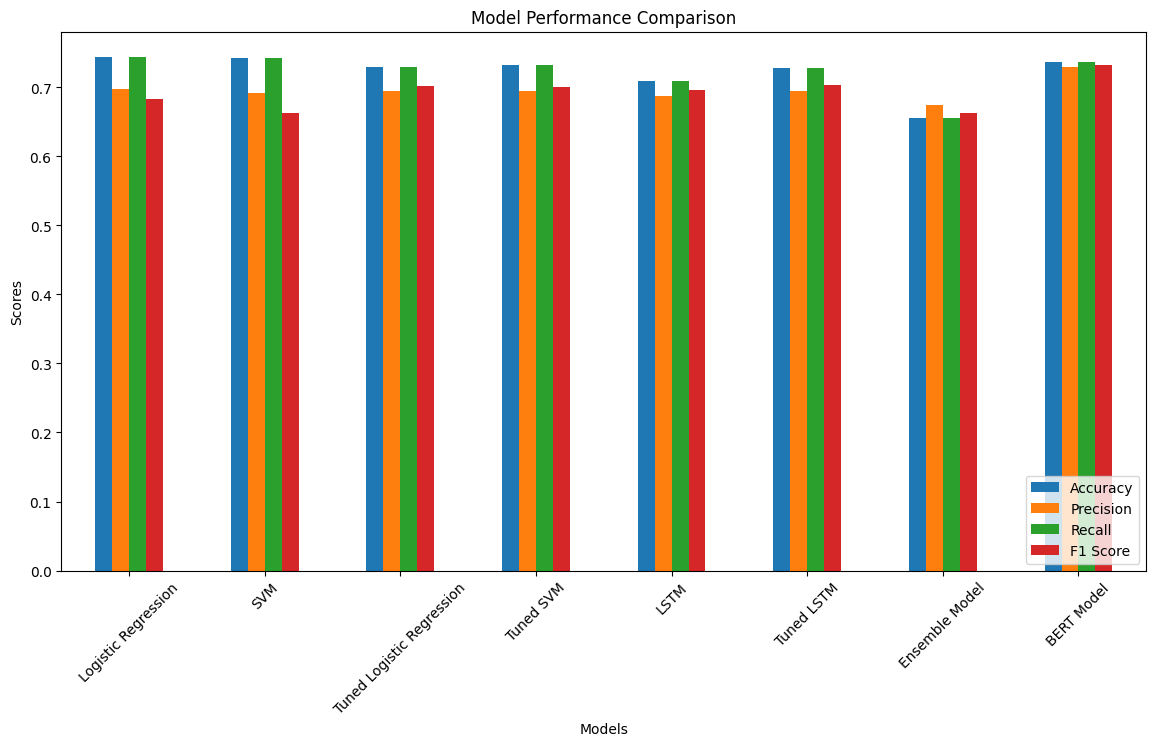

In [53]:
# Plotting the results
performance_df.set_index('Model').plot(kind='bar', figsize=(14, 7), rot=45)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.show()

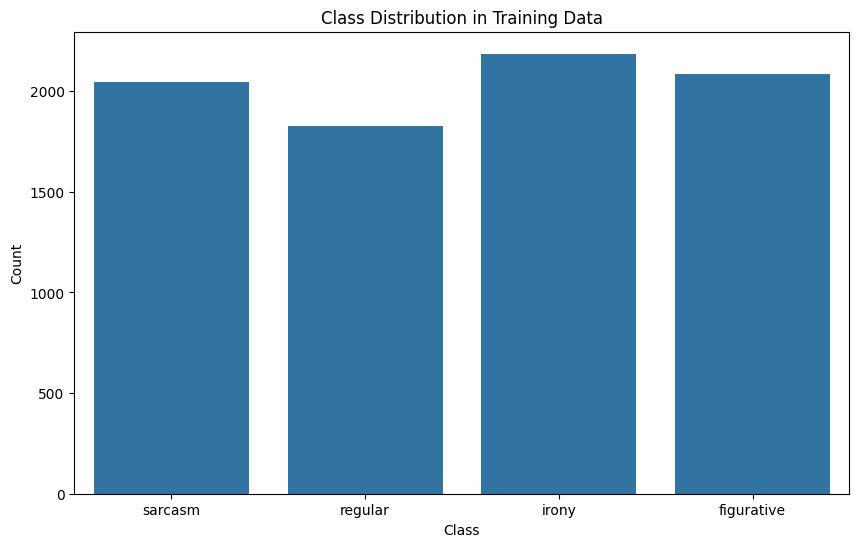

In [54]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

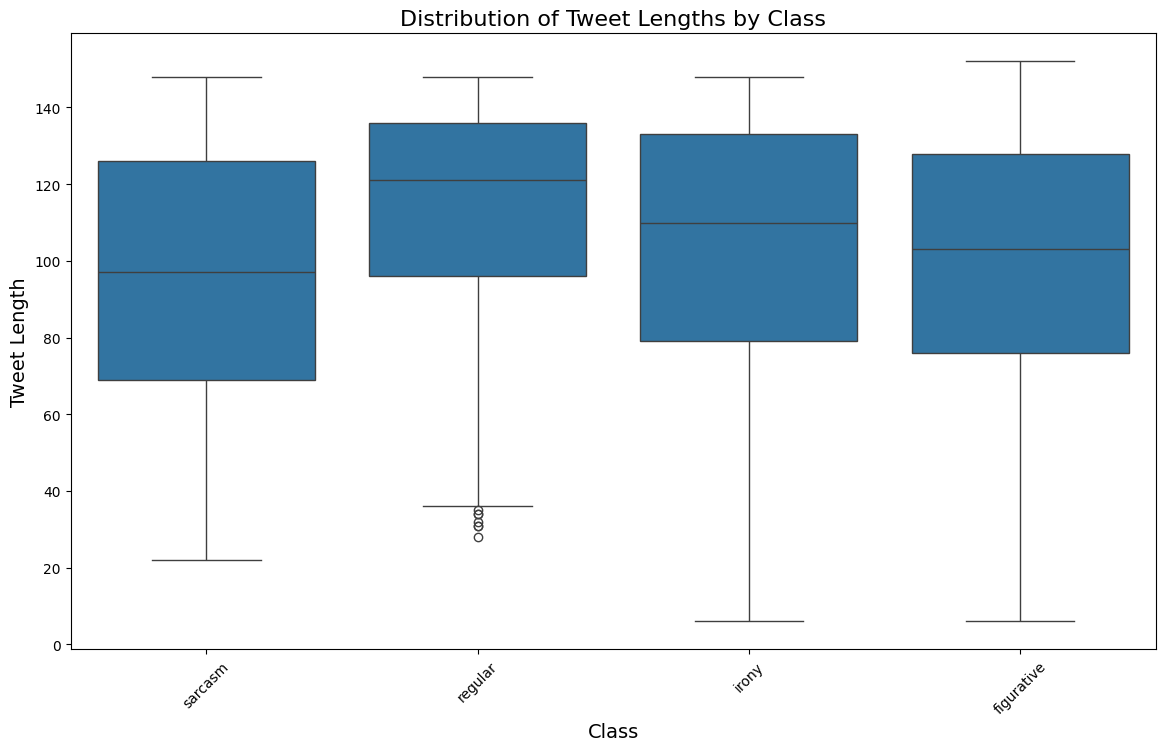

In [55]:
# Tweet Length Distribution
plt.figure(figsize=(14, 8))
sns.boxplot(x='class', y='tweet_length', data=train_data)
plt.title('Distribution of Tweet Lengths by Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Tweet Length', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [56]:
# Most Common Words
common_words = word_freq.most_common(10)
print("Most common words:\n", common_words)


Most common words:
 [('the', 3480), ('to', 2548), ('a', 2201), ('i', 1606), ('of', 1524), ('is', 1442), ('in', 1413), ('and', 1291), ('for', 1109), ('you', 1099)]


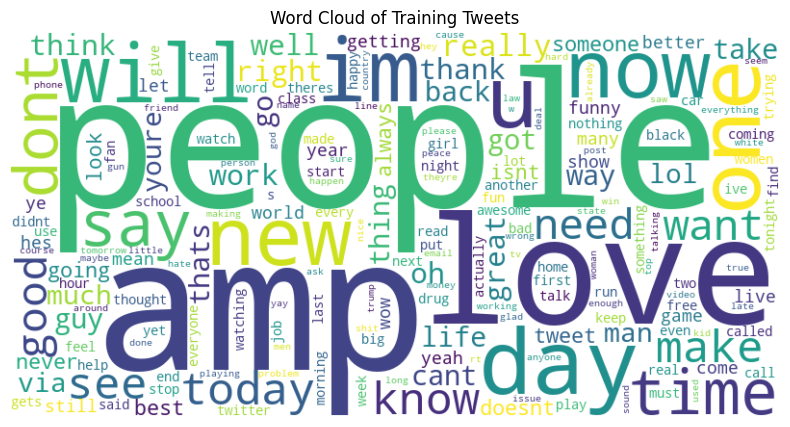

In [57]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Training Tweets')
plt.axis('off')
plt.show()


In [58]:
# Display classification reports for all models
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Tuned Logistic Regression with SMOTE Classification Report:\n", classification_report(y_test, y_pred_lr_tuned))
print("Tuned SVM with SMOTE Classification Report:\n", classification_report(y_test, y_pred_svm_tuned))
print("LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm))
print("Tuned LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm_tuned))
print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("BERT Model Classification Report:\n", classification_report(y_test, y_pred_bert))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85      6023
           1       0.52      0.14      0.22      2105

    accuracy                           0.74      8128
   macro avg       0.64      0.55      0.53      8128
weighted avg       0.70      0.74      0.68      8128

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      6023
           1       0.52      0.08      0.13      2105

    accuracy                           0.74      8128
   macro avg       0.64      0.53      0.49      8128
weighted avg       0.69      0.74      0.66      8128

Tuned Logistic Regression with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      6023
           1       0.46      0.26      0.34      2105

    accuracy                           0.73      

In [60]:
# Consolidated Insights
total_data_size = len(train_data) + len(test_data)
insights = {
    "Class Distribution": train_data['class'].value_counts().to_dict(),
    "Tweet Length Stats": train_data['tweet_length'].describe().to_dict(),
    "Most Common Words": common_words,
    "Total Dataset Size": total_data_size,
    "Training Sample Size": len(train_data),
    "Test Sample Size": len(test_data)
}

print("\nConsolidated Insights:\n")
for key, value in insights.items():
    print(f"{key}: {value}")


Consolidated Insights:

Class Distribution: {'irony': 2186, 'figurative': 2086, 'sarcasm': 2044, 'regular': 1825}
Tweet Length Stats: {'count': 8141.0, 'mean': 102.87249723621177, 'std': 30.706047976346657, 'min': 6.0, '25%': 78.0, '50%': 109.0, '75%': 132.0, 'max': 152.0}
Most Common Words: [('the', 3480), ('to', 2548), ('a', 2201), ('i', 1606), ('of', 1524), ('is', 1442), ('in', 1413), ('and', 1291), ('for', 1109), ('you', 1099)]
Total Dataset Size: 16269
Training Sample Size: 8141
Test Sample Size: 8128
